### Add index to non zero and zero shapefiles

The aim here is to add all the values of weather variables for each polygon in the zero and non zero shapefiles. This is needed for the ignition modelling. 

Here the aim is first to find the lat - long index for each row of the shapefile.

Then, we iterate through each .nc file and append for each row the weather variable value.



In [1]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import geopy
from geopy import distance
from IPython.display import display, clear_output
import rioxarray
from shapely.geometry import mapping

#### Open netcdf file and create list of lon / lat indices where FWI is available

In [2]:
# We just need one file 
year = "2000" 
month = "08"
path = "O:/Climate-and-Energy-Policy/CERM/Projects/Wildfire/Data/ERA5-land/unprocess/FWI-variables/Europe/"
fname = path + "/Derived-FWI-ERA5-land/" + year + "-" + month + ".nc"


In [3]:
fname

'O:/Climate-and-Energy-Policy/CERM/Projects/Wildfire/Data/ERA5-land/unprocess/FWI-variables/Europe//Derived-FWI-ERA5-land/2000-08.nc'

In [4]:
ds = xr.open_dataset(fname)
ds = ds.isel(time = 0)
ds

<xarray.Dataset> Size: 3MB
Dimensions:     (latitude: 451, longitude: 751)
Coordinates:
    number      int32 4B ...
    time        datetime64[ns] 8B 2000-08-01
    surface     float64 8B ...
  * latitude    (latitude) float64 4kB 75.0 74.9 74.8 74.7 ... 30.2 30.1 30.0
  * longitude   (longitude) float64 6kB -30.0 -29.9 -29.8 ... 44.8 44.9 45.0
    valid_time  datetime64[ns] 8B ...
Data variables:
    fwi         (latitude, longitude) float64 3MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-06-18T23:47 GRIB to CDM+CF via cfgrib-0.9.1...

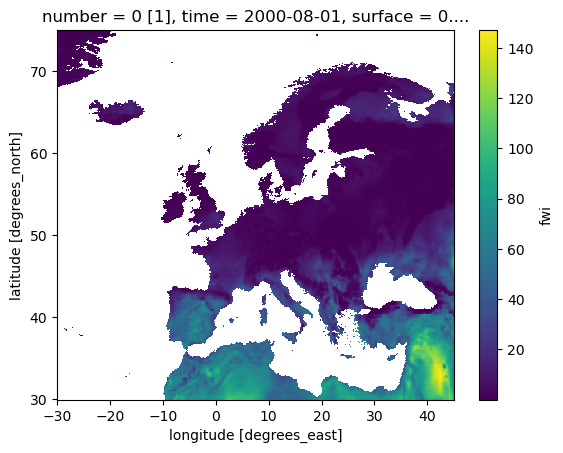

In [5]:
ds.fwi.plot()

In [6]:
ds = ds.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)

In [7]:
ds = ds.rio.write_crs("epsg:4326", inplace=True)

In [8]:
shp = gpd.read_file("O:/Climate-and-Energy-Policy/CERM/Projects/Wildfire/Data/ML-data-Europe-gridded/grid/europe_10km_grid.shp")

In [9]:
shp.head()

,id,geometry
0,68467.0,"POLYGON ((4053879.27 2675289.001, 4063879.27 2..."
1,68468.0,"POLYGON ((4063494.246 2659010.778, 4062388.158..."
2,68474.0,"POLYGON ((4054706.808 2599863.56, 4058556.835 ..."
3,68475.0,"POLYGON ((4053879.27 2595289.001, 4063879.27 2..."
4,68476.0,"POLYGON ((4053879.27 2585289.001, 4063879.27 2..."


<Axes: >

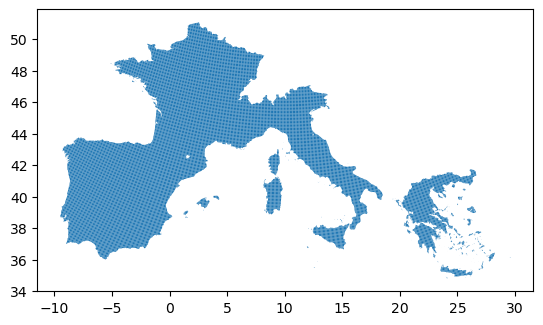

In [10]:
shp.to_crs(4326).plot()

In [ ]:
ds = ds.rio.clip(shp.geometry.apply(mapping), shp.crs, drop = False)

In [ ]:
ds.fwi.plot()

##### Probably a slow solution if for a larger region but will try that for now 

In [ ]:
df = pd.DataFrame(columns = ['lon', 'lat', 'i', 'j'])
df

In [ ]:
counter = 0 
lons = []
lats = []
Is = []
Js = []

for i, lon in enumerate(ds.longitude.values):
    for j, lat in enumerate(ds.latitude.values):
        if np.isnan(ds.fwi.values[j, i]) == False:
            lons.append(lon)
            lats.append(lat)
            Is.append(i)
            Js.append(j)


In [ ]:
df['lon'] = lons
df['lat'] = lats
df['i'] = Is
df['j'] = Js

In [ ]:
df

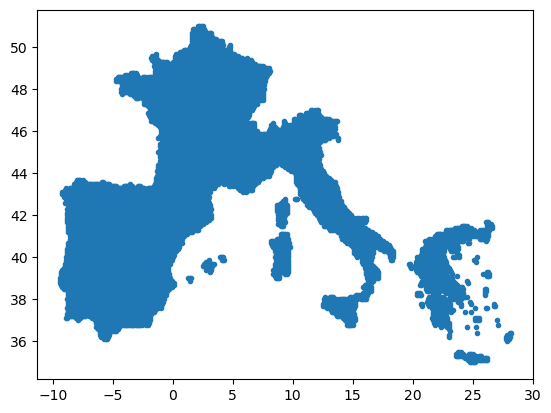

In [18]:
fig, ax = plt.subplots()
ax.plot(df.lon, df.lat,'.')

#### Assign to each polygon the corresponding closest point

##### Calculate the centroid of each polygon and convert it to lon / lat - again probably slow but will do for now


In [19]:
shp['centre'] = shp.centroid.to_crs(4326)

In [20]:
import time


In [21]:
ind_lon = []
ind_lat = []
lons = []
lats = []
missed_ids= []
t0 = time.time()
for i, row in shp.iterrows():
    print(i)
    dists = []
    lat_search = row.centre.coords.xy[1][0]
    lon_search = row.centre.coords.xy[0][0]

    # Create a searchbox to calculate distances in
    df_search = df[((df.lat > (lat_search -0.5)) & (df.lat < (lat_search + 0.5))) & ((df.lon > (lon_search -0.5)) & (df.lon < (lon_search + 0.5)))]
    df_search = df_search

    for j, r in df_search.iterrows():
        dists.append(geopy.distance.geodesic((lat_search, lon_search), (df_search['lat'][j], df_search['lon'][j])).km)

    # Some points are not located within 0.5 degrees of the search lon lat (islands in the Med)
    try:
        arg = np.nanargmin(dists)
        arg = df_search.iloc[arg, :].name # need number of the big list not subsample
        ind_lon.append(df['i'][arg])
        ind_lat.append(df['j'][arg])
        lons.append(df['lon'][arg])
        lats.append(df['lat'][arg])
    except Exception as e: 
        print(e)
        missed_ids.append(int(row.id))
        ind_lon.append(np.nan)
        ind_lat.append(np.nan)
        lons.append(np.nan)
        lats.append(np.nan)
        
    clear_output(wait=True)
  
t1 = time.time()
print((t1-t0)/60)

6.406769120693207


In [22]:
missed_ids

[78261,
 78262,
 78481,
 78482,
 79375,
 79595,
 80031,
 80251,
 80440,
 84398,
 101131,
 101570,
 105745,
 105965,
 106184,
 106189,
 106403,
 106404,
 106408,
 106409,
 106623,
 106624,
 106627,
 106628,
 106629,
 106636,
 106848,
 106849,
 106854,
 107070,
 107076,
 107511,
 107735,
 107960,
 107961,
 108179,
 108180,
 108181,
 108394,
 108395,
 108396,
 108397,
 108398,
 108399,
 108400,
 108614,
 108615,
 108616,
 108617,
 108618,
 108619,
 108838,
 112786,
 113006,
 113226]

In [23]:
shp['i'] = ind_lon
shp['j'] = ind_lat
shp['lon'] = lons
shp['lat'] = lats

In [24]:
shp

,id,geometry,centre,i,j,lon,lat
0,68467.0,"POLYGON ((4053879.27 2675289.001, 4063879.27 2...",POINT (6.54912 47.09123),365.0,279.0,6.5,47.1
1,68468.0,"POLYGON ((4063494.246 2659010.778, 4062388.158...",POINT (6.55017 47.0125),366.0,280.0,6.6,47.0
2,68474.0,"POLYGON ((4054706.808 2599863.56, 4058556.835 ...",POINT (6.58998 46.4361),366.0,286.0,6.6,46.4
3,68475.0,"POLYGON ((4053879.27 2595289.001, 4063879.27 2...",POINT (6.59569 46.37177),366.0,286.0,6.6,46.4
4,68476.0,"POLYGON ((4053879.27 2585289.001, 4063879.27 2...",POINT (6.6014 46.28182),366.0,287.0,6.6,46.3
...,...,...,...,...,...,...,...
17471,110366.0,"POLYGON ((5954048.339 1676431.673, 5954317.113...",POINT (28.23503 36.39192),582.0,386.0,28.2,36.4
17472,110367.0,"MULTIPOLYGON (((5955063.479 1674029.759, 59546...",POINT (28.23108 36.37672),582.0,386.0,28.2,36.4
17473,112786.0,"POLYGON ((6071543.557 1678322.901, 6070929.886...",POINT (29.49478 36.15433),NaN,NaN,NaN,NaN
17474,113006.0,"MULTIPOLYGON (((6083832.405 1677528.343, 60838...",POINT (29.58453 36.14176),NaN,NaN,NaN,NaN


#### Test for one time step 

In [25]:
fwis = []
t0 = time.time()
for i, row in shp.iterrows():
    try: 
        fwis.append(ds.fwi.values[int(row.j), int(row.i)])
    except Exception as e: 
        fwis.append(np.nan)
t1 = time.time()
print(t1 -t0)

1.2788710594177246


In [26]:
t0 = time.time()
js = list(shp.j)
Is = list(shp.i)

t1 = time.time()
print(t1 -t0)

0.004051685333251953


In [27]:
shp['fwi'] = fwis


In [28]:
shp_smp = shp.iloc[::10, ::].reset_index(drop=True)


(35.0, 55.0)

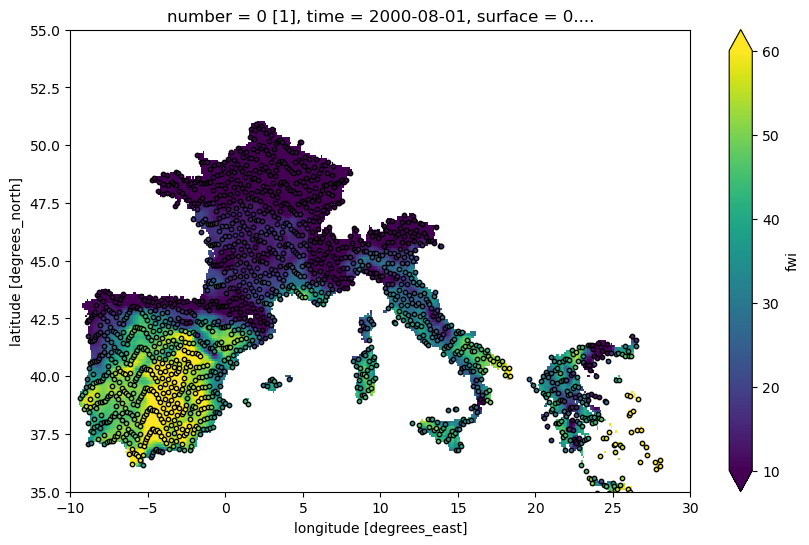

In [29]:
fig, ax = plt.subplots(figsize = (10, 6))
ds.fwi.plot(ax = ax, zorder = 0, vmin = 10, vmax = 60)
for i, row in shp_smp.iterrows():
    print(i)
    ax.scatter(row.centre.coords.xy[0][0], row.centre.coords.xy[1][0], c = row.fwi, s = 10, vmin = 10, vmax = 60, edgecolor = 'k')
    clear_output(wait=True)
ax.set_xlim([-10,30])
ax.set_ylim([35, 55])

In [30]:
shp = shp.dropna().reset_index(drop = True)

In [31]:
shp['i'] = shp.i.astype('int64')
shp['j'] = shp.j.astype('int64')

In [32]:
shp

,id,geometry,centre,i,j,lon,lat,fwi
0,68467.0,"POLYGON ((4053879.27 2675289.001, 4063879.27 2...",POINT (6.54912 47.09123),365,279,6.5,47.1,1.661669
1,68468.0,"POLYGON ((4063494.246 2659010.778, 4062388.158...",POINT (6.55017 47.0125),366,280,6.6,47.0,1.152148
2,68474.0,"POLYGON ((4054706.808 2599863.56, 4058556.835 ...",POINT (6.58998 46.4361),366,286,6.6,46.4,1.521994
3,68475.0,"POLYGON ((4053879.27 2595289.001, 4063879.27 2...",POINT (6.59569 46.37177),366,286,6.6,46.4,1.521994
4,68476.0,"POLYGON ((4053879.27 2585289.001, 4063879.27 2...",POINT (6.6014 46.28182),366,287,6.6,46.3,1.955098
...,...,...,...,...,...,...,...,...
17416,110148.0,"POLYGON ((5952451.677 1659086.956, 5951963.526...",POINT (28.1277 36.27154),581,387,28.1,36.3,73.300376
17417,110149.0,"POLYGON ((5950523.926 1654415.383, 5950382.121...",POINT (28.09336 36.19347),581,388,28.1,36.2,69.540404
17418,110150.0,"POLYGON ((5946138.759 1644417.268, 5946132.192...",POINT (28.06147 36.09921),580,389,28.0,36.1,65.234866
17419,110366.0,"POLYGON ((5954048.339 1676431.673, 5954317.113...",POINT (28.23503 36.39192),582,386,28.2,36.4,76.338439


#### Repeat for all time steps 


In [33]:
# Open dataframe
#shp = pd.read_csv('campana-fwi.csv')
js = list(shp.j)
Is = list(shp.i)


In [34]:
Case_Study = False # If False, the whole European domain is downloaded 

CS_name = 'Crete' 

In [35]:
path

'O:/Climate-and-Energy-Policy/CERM/Projects/Wildfire/Data/ERA5-land/unprocess/FWI-variables/Europe/'

In [36]:
save_path = "O:/Climate-and-Energy-Policy/CERM/Projects/Wildfire/Data/ML-data-Europe-gridded/weather/"

In [37]:
years =  ["2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023"]

months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

In [38]:
variables = ['temp', 'prcp', 'rhum', 'wind']
for var in variables:
    t0 = time.time()
    for year in years:
        print(year)
        shp_new = shp.iloc[:, :15].copy()
        for month in months:
     
            print(month)
            
            if var == 'swvl1':
                fname = "O:/Climate-and-Energy-Policy/CERM/Projects/Wildfire/Data/ERA5-land/unprocess/FWI-variables/Europe/ERA5-land/" + year + "-" + month + "-soil.grib"
                ds = xr.open_dataset(fname, engine = "cfgrib")
            elif var == 'fwi':
                fname = "O:/Climate-and-Energy-Policy/CERM/Projects/Wildfire/FWI/Europe/Derived-FWI-ERA5-land/" + year + "-" + month + ".nc"
                ds = xr.open_dataset(fname)
            else:
                fname = path + "/Derived-FWI-ERA5-land/vars-" + year + "-" + month + ".nc"
                ds = xr.open_dataset(fname)
            
            for t in range(len(ds.time)):
                print(year + ' ' + month + ' ' + str(t))
                vals = ds[var].isel(time = t).values[js, Is]
                shp_new[year + month + str(t)] = vals
    
                clear_output(wait=True)
        shp_new.to_csv(save_path + '/' + var + '-' + year +  '.csv')
    t1 = time.time()
    print((t1-t0)/60)
        

2021
01


Can't create file 'O:/Climate-and-Energy-Policy/CERM/Projects/Wildfire/Data/ERA5-land/unprocess/FWI-variables/Europe/ERA5-land/2021-01-soil.grib.5b7b6.idx'
Traceback (most recent call last):
  File "C:\Users\ophme\AppData\Local\anaconda3\envs\wildfire\Lib\site-packages\cfgrib\messages.py", line 273, in itervalues
    yield self.filestream.message_from_file(file, errors=errors)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ophme\AppData\Local\anaconda3\envs\wildfire\Lib\site-packages\cfgrib\messages.py", line 340, in message_from_file
    return Message.from_file(file, offset, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ophme\AppData\Local\anaconda3\envs\wildfire\Lib\site-packages\cfgrib\messages.py", line 104, in from_file
    raise EOFError("End of file: %r" % file)
EOFError: End of file: <_io.BufferedReader name='O:/Climate-and-Energy-Policy/CERM/Projects/Wildfire/Data/ERA5-land/unprocess/FWI-variables/Europe/ERA

EOFError: No valid message found: 'O:/Climate-and-Energy-Policy/CERM/Projects/Wildfire/Data/ERA5-land/unprocess/FWI-variables/Europe/ERA5-land/2021-01-soil.grib'

### Concatenate all yearly files together 

In [ ]:
years =  ["2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023"]

for var in variables:
    df1 = pd.read_csv(save_path + '/' + var + '-2008.csv')
    total = len(df1.columns)
    for year in years:
        df2 = pd.read_csv(save_path + '/' + var + '-' + year + '.csv')
        print(len(df2.iloc[:, 10:].columns))
        total = total + len(df2.iloc[:, 10:].columns)
        df1 = df1.merge(df2, how = 'outer')
        
    df1.to_csv(save_path + '/' + var + '-2008-2023.csv')